In [1]:
#To allocate memorey for gpu(here we are using 50%)
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
from IPython.display import Image

In [4]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

Using TensorFlow backend.


In [5]:
FAST_RUN = False
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [11]:
import os
filenames = os.listdir(r"C:/Users/Balaji/Documents/Machine Learning/defect de/Defect-Detection-of-PCB-main/train")
labels = []
for filename in filenames:
    label = filename.split(' ')[0]
    if label == 'good':
        labels.append(0)
    else:
        labels.append(1)
data = pd.DataFrame({
       'filename': filenames,
        'label': labels
})        

In [12]:
data.head(5)

,filename,label
0,bad (1)k.jpeg,1
1,bad (10)k.jpeg,1
2,bad (100)k.jpeg,1
3,bad (101)k.jpeg,1
4,bad (102)k.jpeg,1


<AxesSubplot:>

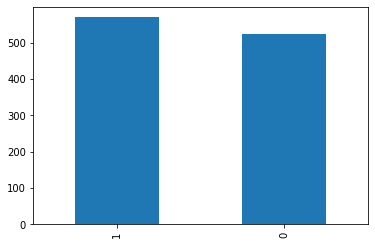

In [13]:
data['label'].value_counts().plot.bar()

In [17]:
base_model = MobileNet(weights='imagenet',include_top=False)

C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 2s 0us/step


In [20]:
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(1024,activation='relu')(x)#we add dense layers so that the model can learn more complex functions and classify for better results
x = Dense(1024,activation='relu')(x)#dense layer 2
x = Dense(512,activation='relu')(x)#dense layer 3
pred = Dense(2,activation='softmax')(x)#final layer with softmax

In [22]:
model = Model(inputs=base_model.input,outputs=pred)

In [23]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
for layer in model.layers[:20]:
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

In [25]:
early_stop = EarlyStopping(patience=10)

In [26]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [28]:
callbacks = [early_stop, learning_rate_reduction]

In [29]:
data['label'] = data['label'].replace({0:'Good',1:'Bad'})

In [30]:
train_df, validate_df = train_test_split(data, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

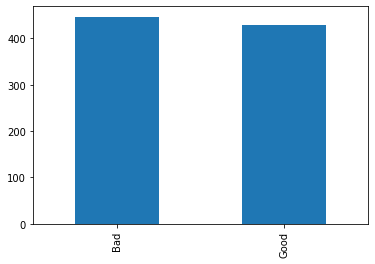

In [31]:
train_df['label'].value_counts().plot.bar()

<AxesSubplot:>

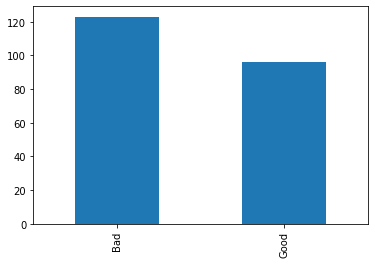

In [32]:
validate_df['label'].value_counts().plot.bar()

In [33]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [34]:
train_datagen = ImageDataGenerator(rotation_range=15,rescale=1./255,shear_range=0.1,zoom_range=0.2,horizontal_flip=True,width_shift_range=0.1,height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(train_df,r"C:/Users/Balaji/Documents/Machine Learning/defect de/Defect-Detection-of-PCB-main/train",x_col='filename',y_col='label',target_size=IMAGE_SIZE,class_mode='categorical',batch_size=batch_size)

Found 876 validated image filenames belonging to 2 classes.


In [36]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"C:/Users/Balaji/Documents/Machine Learning/defect de/Defect-Detection-of-PCB-main/train", 
    x_col='filename',
    y_col='label',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)    

Found 219 validated image filenames belonging to 2 classes.


In [37]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50


C:\ProgramData\Anaconda3\envs\gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


58/58 [==============================] - 210s 4s/step - loss: 0.5587 - accuracy: 0.7840 - val_loss: 5.3107 - val_accuracy: 0.5143
Epoch 2/50
58/58 [==============================] - 175s 3s/step - loss: 0.2678 - accuracy: 0.9175 - val_loss: 0.4113 - val_accuracy: 0.8627
Epoch 3/50
58/58 [==============================] - 173s 3s/step - loss: 0.2319 - accuracy: 0.9257 - val_loss: 0.0082 - val_accuracy: 0.9265
Epoch 4/50
58/58 [==============================] - 174s 3s/step - loss: 0.2026 - accuracy: 0.9373 - val_loss: 0.9479 - val_accuracy: 0.8971
Epoch 5/50
58/58 [==============================] - 175s 3s/step - loss: 0.2420 - accuracy: 0.9310 - val_loss: 0.0172 - val_accuracy: 0.9216

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
58/58 [==============================] - 171s 3s/step - loss: 0.1658 - accuracy: 0.9448 - val_loss: 1.0245 - val_accuracy: 0.9461
Epoch 7/50
58/58 [==============================] - 174s 3s/step - loss: 0.0731 - ac

In [38]:
model.save_weights("model.h5")

In [39]:
model.save("model.h5")